In [ ]:
!git clone https://github.com/JunkyByte/easy_ViTPose.git
%cd easy_ViTPose
!pip install -r requirements.txt
!pip install -e .
!pip install huggingface_hub
!pip install onnx onnxruntime-gpu

Cloning into 'easy_ViTPose'...
remote: Enumerating objects: 682, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 682 (delta 55), reused 62 (delta 26), pack-reused 583
Receiving objects: 100% (682/682), 8.71 MiB | 19.44 MiB/s, done.
Resolving deltas: 100% (392/392), done.
/content/easy_ViTPose/easy_ViTPose/easy_ViTPose
Obtaining file:///content/easy_ViTPose/easy_ViTPose/easy_ViTPose
  Preparing metadata (setup.py) ... done
  Attempting uninstall: easy-ViTPose
    Found existing installation: easy-ViTPose 0.4
    Uninstalling easy-ViTPose-0.4:
      Successfully uninstalled easy-ViTPose-0.4
  Running setup.py develop for easy-ViTPose


In [ ]:
#@title Choose model and run this cell
#@markdown Only ONNX and torch models here

MODEL_TYPE = 'onnx'  #@param ["onnx", "torch"]
MODEL_SIZE = 'l'  #@param ['s', 'b', 'l', 'h']
YOLO_TYPE = 'onnx'  #@param ['onnx', 'torch']
YOLO_SIZE = 'n'  #@param ['s', 'n']
ext = {'tensorrt': '.engine', 'onnx': '.onnx', 'torch': '.pth'}[MODEL_TYPE]
ext_yolo = {'onnx': '.onnx', 'torch': '.pt'}[YOLO_TYPE]

In [ ]:
import os
from huggingface_hub import hf_hub_download
REPO_ID = 'JunkyByte/easy_ViTPose'
FILENAME = os.path.join(MODEL_TYPE, 'vitpose-25-' + MODEL_SIZE) + ext
FILENAME_YOLO = 'yolov5/yolov5' + YOLO_SIZE + ext_yolo

print(f'Downloading model {REPO_ID}/{FILENAME}')
model_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)
yolo_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME_YOLO)

In [ ]:
%cd /content/easy_ViTPose/easy_ViTPose/
!ls

/content/easy_ViTPose/easy_ViTPose
configs       easy_ViTPose.egg-info  sort.py	    utils_engine.py
config.yaml   inference.py	     to_onnx.ipynb  vit_models
datasets      __init__.py	     to_trt.ipynb   vit_utils
easy_ViTPose  __pycache__	     train.py	    다운로드.jpeg


In [ ]:
# If you get an error from PIL restart environment and rerun this cell to update packages version
# from easy_ViTPose.inference import VitInference
import abc
import time
from typing import Optional
import json
import os
import tqdm

from PIL import Image
import cv2
import numpy as np
import torch

from configs.ViTPose_common import data_cfg
from vit_models.model import ViTPose
from vit_utils.top_down_eval import keypoints_from_heatmaps
from vit_utils.visualization import draw_points_and_skeleton, joints_dict
from vit_utils.inference import pad_image, VideoReader, NumpyEncoder, draw_bboxes
from sort import Sort

try:  # Add bools -> error stack
    import pycuda.driver as cuda  # noqa: [F401]
    import pycuda.autoinit  # noqa: [F401]
    import utils_engine as engine_utils
    import tensorrt as trt
    has_trt = True
except ModuleNotFoundError:
    pass

try:
    import onnxruntime
    has_onnx = True
except ModuleNotFoundError:
    pass

__all__ = ['VitInference']
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]


class VitInference:
    """
    Class for performing inference using ViTPose models with YOLOv5 human detection detection and SORT tracking.

    Args:
        model (str): Path to the ViT model file (.pth, .onnx, .engine).
        yolo_name (str): Name of the YOLOv5 model to load.
        model_name (str, optional): Name of the ViT model architecture to use. Valid values are 's', 'b', 'l', 'h'.
                                    Defaults to None, is necessary when using .pth checkpoints.
        yolo_size (int, optional): Size of the input image for YOLOv5 model. Defaults to 320.
        device (str, optional): Device to use for inference. Defaults to 'cuda' if available, else 'cpu'.
        is_video (bool, optional): Flag indicating if the input is video. Defaults to False.
        single_pose (bool, optional): Flag indicating if the video (on images this flag has no effect) will contain a single pose.
                                      In this case the SORT tracker is not used (increasing performance) but people id tracking
                                      won't be consistent among frames.
        yolo_step (int, optional): The tracker can be used to predict the bboxes instead of yolo for performance,
                                   this flag specifies how often yolo is applied (e.g. 1 applies yolo every frame).
                                   This does not have any effect when is_video is False.
    """

    def __init__(self, model: str,
                 yolo_name: str,
                 model_name: Optional[str] = None,
                 yolo_size: Optional[int] = 320,
                 device: Optional[str] = None,
                 is_video: Optional[bool] = False,
                 single_pose: Optional[bool] = False,
                 yolo_step: Optional[int] = 1):
        assert os.path.isfile(model), f'The model file {model} does not exist'
        assert os.path.isfile(yolo_name), f'The YOLOv5 model {yolo_name} does not exist'

        # Device priority is cuda / mps / cpu
        if device is None:
            if torch.cuda.is_available():
                device = 'cuda'
            elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
                device = 'mps'
            else:
                device = 'cpu'

        self.device = torch.device(device)
        self.yolo = torch.hub.load("ultralytics/yolov5", "custom", yolo_name)
        self.yolo.to(self.device)
        self.yolo.classes = [0]
        self.yolo_size = yolo_size
        self.yolo_step = yolo_step
        self.is_video = is_video
        self.single_pose = single_pose
        self.reset()

        # State saving during inference
        self.save_state = True  # Can be disabled manually
        self._img = None
        self._yolo_res = None
        self._tracker_res = None
        self._keypoints = None

        # Use extension to decide which kind of model has been loaded
        use_onnx = model.endswith('.onnx')
        use_trt = model.endswith('.engine')

        assert model_name in [None, 's', 'b', 'l', 'h'], \
            f'The model name {model_name} is not valid'

        # onnx / trt models do not require model_cfg specification
        if model_name is None:
            assert use_onnx or use_trt, \
                'Specify the model_name if not using onnx / trt'
        else:
            if model_name == 's':
                from configs.ViTPose_small_coco_256x192 import model as model_cfg
            elif model_name == 'b':
                from configs.ViTPose_base_coco_256x192 import model as model_cfg
            elif model_name == 'l':
                from configs.ViTPose_large_coco_256x192 import model as model_cfg
            elif model_name == 'h':
                from configs.ViTPose_huge_coco_256x192 import model as model_cfg

        self.target_size = data_cfg['image_size']
        if use_onnx:
            self._ort_session = onnxruntime.InferenceSession(model,
                                                             providers=['CUDAExecutionProvider',
                                                                        'CPUExecutionProvider'])
            inf_fn = self._inference_onnx
        elif use_trt:
            logger = trt.Logger(trt.Logger.ERROR)
            trt_runtime = trt.Runtime(logger)
            trt_engine = engine_utils.load_engine(trt_runtime, model)

            # This allocates memory for network inputs/outputs on both CPU and GPU
            self._inputs, self._outputs, self._bindings, self._stream = \
                engine_utils.allocate_buffers(trt_engine)
            # Execution context is needed for inference
            self._context = trt_engine.create_execution_context()
            inf_fn = self._inference_trt
        else:
            self._vit_pose = ViTPose(model_cfg)
            self._vit_pose.eval()

            ckpt = torch.load(model, map_location='cpu')
            if 'state_dict' in ckpt:
                self._vit_pose.load_state_dict(ckpt['state_dict'])
            else:
                self._vit_pose.load_state_dict(ckpt)
            self._vit_pose.to(device)
            inf_fn = self._inference_torch

        # Override inference with selected engine
        self._inference = inf_fn

    def reset(self):
        """
        Reset the inference class to be ready for a new video.
        This will reset the internal counter of frames, on videos
        this is necessary to reset the tracker.
        """
        min_hits = 3 if self.yolo_step == 1 else 1
        use_tracker = self.is_video and not self.single_pose
        self.tracker = Sort(max_age=self.yolo_step,
                            min_hits=min_hits,
                            iou_threshold=0.3) if use_tracker else None  # TODO: Params
        self.frame_counter = 0

    @classmethod
    def postprocess(cls, heatmaps, org_w, org_h):
        """
        Postprocess the heatmaps to obtain keypoints and their probabilities.

        Args:
            heatmaps (ndarray): Heatmap predictions from the model.
            org_w (int): Original width of the image.
            org_h (int): Original height of the image.

        Returns:
            ndarray: Processed keypoints with probabilities.
        """
        points, prob = keypoints_from_heatmaps(heatmaps=heatmaps,
                                               center=np.array([[org_w // 2,
                                                                 org_h // 2]]),
                                               scale=np.array([[org_w, org_h]]),
                                               unbiased=True, use_udp=True)
        return np.concatenate([points[:, :, ::-1], prob], axis=2)

    @abc.abstractmethod
    def _inference(img: np.ndarray) -> np.ndarray:
        """
        Abstract method for performing inference on an image.
        It is overloaded by each inference engine.

        Args:
            img (ndarray): Input image for inference.

        Returns:
            ndarray: Inference results.
        """
        raise NotImplementedError

    def inference(self, img: np.ndarray) -> np.ndarray:
        """
        Perform inference on the input image.

        Args:
            img (ndarray): Input image for inference in RGB format.

        Returns:
            ndarray: Inference results.
        """

        # First use YOLOv5 for detection
        res_pd = np.empty((0, 5))
        results = None
        if (self.tracker is None or
           (self.frame_counter % self.yolo_step == 0 or self.frame_counter < 3)):
            results = self.yolo(img, size=self.yolo_size)
            res_pd = np.array([r[:5].tolist() for r in  # TODO: Confidence threshold
                               results.pandas().xyxy[0].to_numpy() if r[4] > 0.35]).reshape((-1, 5))
        self.frame_counter += 1

        frame_keypoints = {}
        ids = None
        if self.tracker is not None:
            res_pd = self.tracker.update(res_pd)
            ids = res_pd[:, 5].astype(int).tolist()

        # Prepare boxes for inference
        bboxes = res_pd[:, :4].round().astype(int)
        scores = res_pd[:, 4].tolist()
        pad_bbox = 10

        if ids is None:
            ids = range(len(bboxes))

        for bbox, id in zip(bboxes, ids):
            # TODO: Slightly bigger bbox
            bbox[[0, 2]] = np.clip(bbox[[0, 2]] + [-pad_bbox, pad_bbox], 0, img.shape[1])
            bbox[[1, 3]] = np.clip(bbox[[1, 3]] + [-pad_bbox, pad_bbox], 0, img.shape[0])

            # Crop image and pad to 3/4 aspect ratio
            img_inf = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]
            img_inf, (left_pad, top_pad) = pad_image(img_inf, 3 / 4)

            keypoints = self._inference(img_inf)[0]
            # Transform keypoints to original image
            keypoints[:, :2] += bbox[:2][::-1] - [top_pad, left_pad]
            frame_keypoints[id] = keypoints

        if self.save_state:
            self._img = img
            self._yolo_res = results
            self._tracker_res = (bboxes, ids, scores)
            self._keypoints = frame_keypoints

        return frame_keypoints

    def draw(self, show_yolo=True, show_raw_yolo=False, confidence_threshold=0.5):
        """
        Draw keypoints and bounding boxes on the image.

        Args:
            show_yolo (bool, optional): Whether to show YOLOv5 bounding boxes. Default is True.
            show_raw_yolo (bool, optional): Whether to show raw YOLOv5 bounding boxes. Default is False.

        Returns:
            ndarray: Image with keypoints and bounding boxes drawn.
        """
        img = self._img.copy()
        bboxes, ids, scores = self._tracker_res

        if self._yolo_res is not None and (show_raw_yolo or (self.tracker is None and show_yolo)):
            img = np.array(self._yolo_res.render())[0]

        if show_yolo and self.tracker is not None:
            img = draw_bboxes(img, bboxes, ids, scores)

        img = np.array(img)[..., ::-1]  # RGB to BGR for cv2 modules
        for idx, k in self._keypoints.items():
            img = draw_points_and_skeleton(img.copy(), k,
                                           joints_dict()['coco']['skeleton'],
                                           person_index=idx,
                                           points_color_palette='gist_rainbow',
                                           skeleton_color_palette='jet',
                                           points_palette_samples=10,
                                           confidence_threshold=confidence_threshold)
        return img[..., ::-1], self._keypoints  # Return RGB as original

    def pre_img(self, img):
        org_h, org_w = img.shape[:2]
        img_input = cv2.resize(img, self.target_size, interpolation=cv2.INTER_LINEAR) / 255
        img_input = ((img_input - MEAN) / STD).transpose(2, 0, 1)[None].astype(np.float32)
        return img_input, org_h, org_w

    @torch.no_grad()
    def _inference_torch(self, img: np.ndarray) -> np.ndarray:
        # Prepare input data
        img_input, org_h, org_w = self.pre_img(img)
        img_input = torch.from_numpy(img_input).to(self.device)

        # Feed to model
        heatmaps = self._vit_pose(img_input).detach().cpu().numpy()
        return self.postprocess(heatmaps, org_w, org_h)

    def _inference_onnx(self, img: np.ndarray) -> np.ndarray:
        # Prepare input data
        img_input, org_h, org_w = self.pre_img(img)

        # Feed to model
        ort_inputs = {self._ort_session.get_inputs()[0].name: img_input}
        heatmaps = self._ort_session.run(None, ort_inputs)[0]
        return self.postprocess(heatmaps, org_w, org_h)

    def _inference_trt(self, img: np.ndarray) -> np.ndarray:
        # Prepare input data
        img_input, org_h, org_w = self.pre_img(img)

        # Copy the data to appropriate memory
        np.copyto(self._inputs[0].host, img_input.ravel())
        heatmaps = engine_utils.do_inference(context=self._context,
                                             bindings=self._bindings,
                                             inputs=self._inputs,
                                             outputs=self._outputs,
                                             stream=self._stream)[0]

        # Reshape to output size
        heatmaps = heatmaps.reshape(1, 25, img_input.shape[2] // 4, img_input.shape[3] // 4)
        return self.postprocess(heatmaps, org_w, org_h)

In [ ]:
model = VitInference(model_path, yolo_path, MODEL_SIZE, yolo_size=320, is_video=False)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-8-23 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Loading /root/.cache/huggingface/hub/models--JunkyByte--easy_ViTPose/snapshots/2e599f9067ef175c7e270bafca586d1cf8d3f9df/yolov5/yolov5n.onnx for ONNX Runtime inference...
Adding AutoShape... 


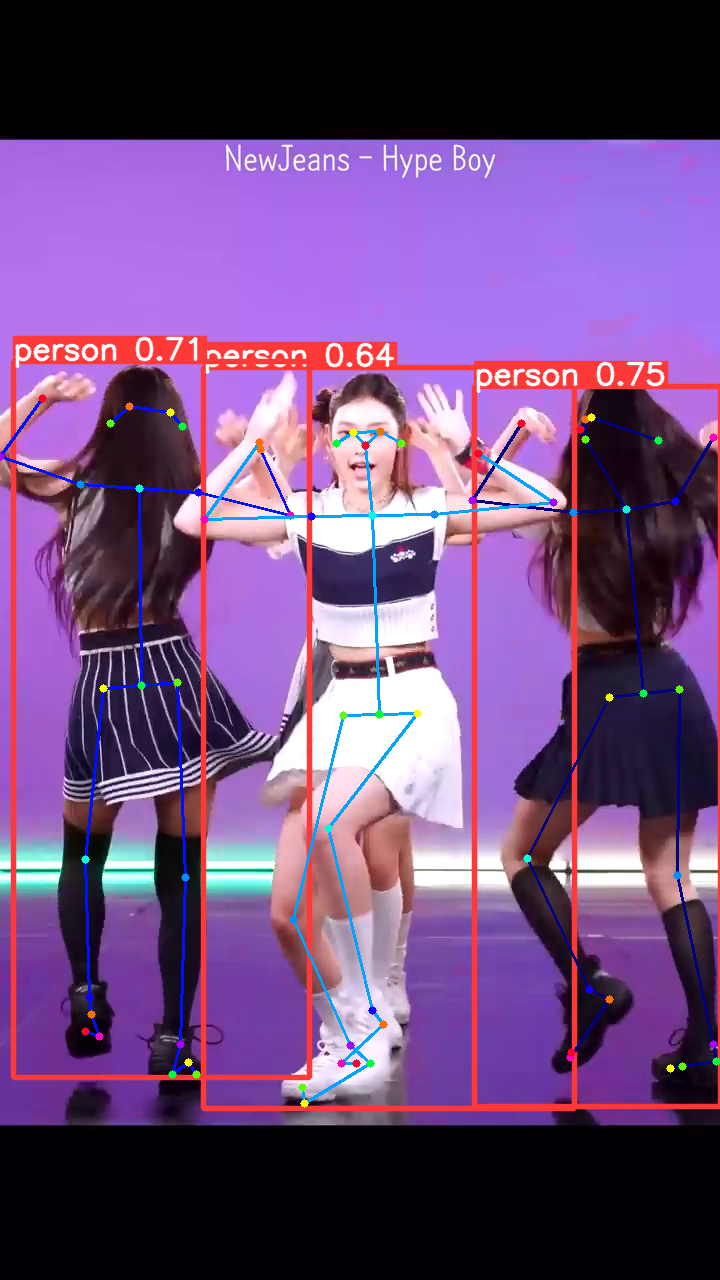

In [ ]:
#@title Custom image
from google.colab import files
import numpy as np
from PIL import Image
from urllib.request import urlopen
import matplotlib.pyplot as plt
from vit_utils.visualization import draw_points_and_skeleton, joints_dict
from google.colab.patches import cv2_imshow

file_path = '/content/drive/MyDrive/sum23/pose_esti/videocut/hypeboy (2)/frame_0.2_024.jpg'
img = np.array(Image.open(file_path))

# img = np.array(Image.open(list(files.upload().keys())[0]), dtype=np.uint8)



frame_keypoints = model.inference(img)
img, key_points = model.draw(show_yolo=True)

cv2_imshow(img[..., ::-1])

In [ ]:
key_points

{0: array([[     429.06,      580.36,     0.66362],
        [      419.9,      585.74,     0.78482],
        [     417.85,      591.73,     0.55507],
        [     439.61,      585.77,     0.94558],
        [     440.94,      658.64,     0.89924],
        [      509.8,      626.21,     0.94932],
        [     512.73,      573.21,      0.9208],
        [     501.74,      675.51,     0.87766],
        [     500.14,      472.14,     0.89933],
        [     437.63,      713.16,     0.61979],
        [     423.72,      521.58,     0.92965],
        [     436.33,      680.32,     0.47104],
        [     697.06,      609.34,     0.83226],
        [     689.98,      679.95,     0.84397],
        [     693.53,      643.81,     0.86241],
        [     858.93,      527.06,     0.96496],
        [     875.66,      677.07,     0.94459],
        [     989.88,      589.02,     0.94326],
        [     1044.9,      713.08,     0.91302],
        [     1057.4,      570.64,     0.84402],
        [     105

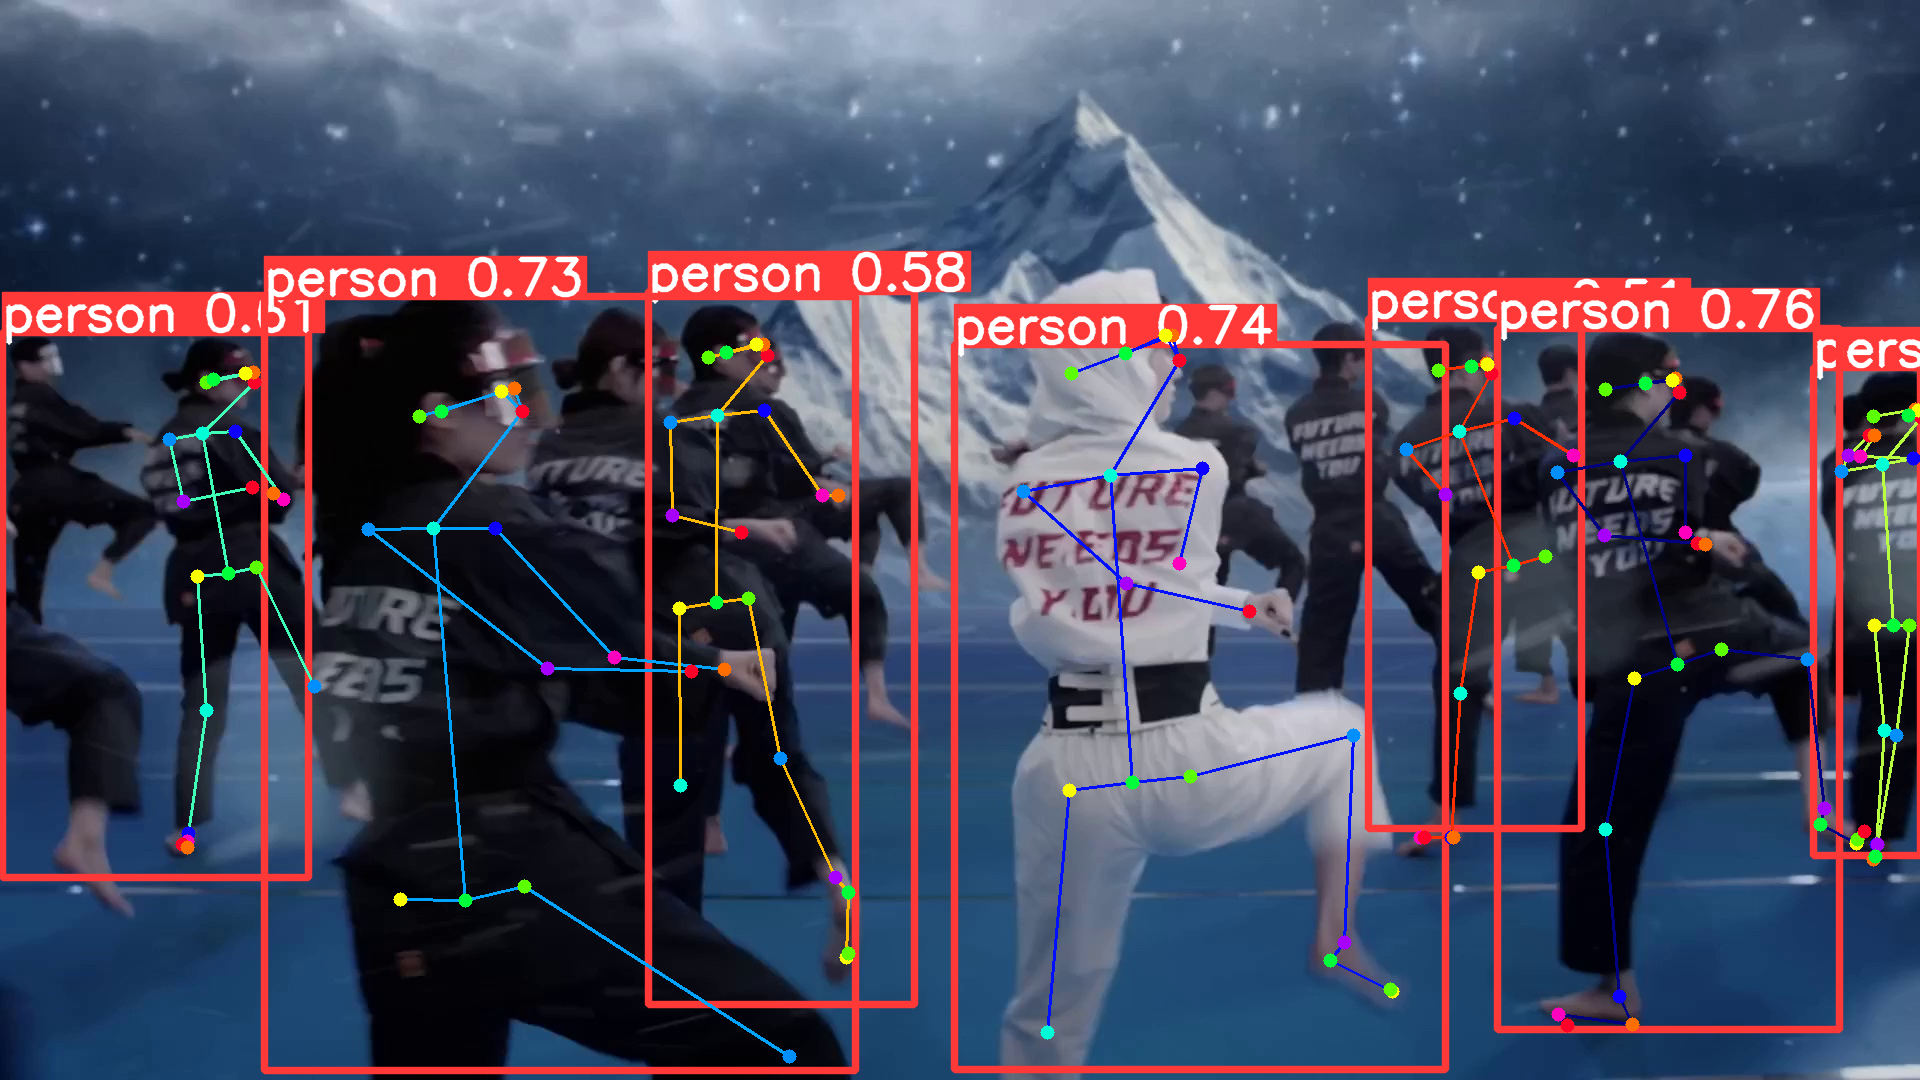

In [ ]:
#@title Custom image
from google.colab import files
import numpy as np
from PIL import Image
from urllib.request import urlopen
import matplotlib.pyplot as plt
from vit_utils.visualization import draw_points_and_skeleton, joints_dict

file_path = '/content/drive/MyDrive/sum23/pose_esti/videocut/FastForward_clip/frame_0.2_025.jpg'
img = np.array(Image.open(file_path))

# img = np.array(Image.open(list(files.upload().keys())[0]), dtype=np.uint8)



frame_keypoints = model.inference(img)
img = model.draw(show_yolo=True)

from google.colab.patches import cv2_imshow
cv2_imshow(img[..., ::-1])